In [1]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
from scipy.stats import norm
import astropy.units as u
import matplotlib.pyplot as plt
from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.spectra.scan import PSScan, GBTPSScan
import pandas
from copy import deepcopy
pandas.set_option('display.max_rows', 100)
from astropy.modeling.fitting import LevMarLSQFitter,LinearLSQFitter
from specutils import Spectrum1D, SpectrumList,SpectralRegion
from specutils.fitting import fit_continuum
import matplotlib.pyplot as plt
from dysh.spectra import dcmeantsys
from dysh.plot.specplot import SpectrumPlot
#%matplotlib notebook

# 1. Create a gaussian spectrum with noise, compute the baseline, remove it, then add the baseline back in

### First, create the spectrum

In [2]:
npts = 1000
x = np.arange(npts)
restfreq = 110.20137*u.GHz
xfreq = restfreq+(x-npts//2)*10*u.kHz
y = 3.14+ np.random.rand(npts)+1000*norm(loc=npts/2,scale=50).pdf(x)
s = Spectrum(flux=y*u.K,spectral_axis=xfreq, rest_value = restfreq,
             velocity_convention='radio',radial_velocity=25*u.Unit('km/s'))
s.velocity

<Quantity [38.60202954, 38.57482548, 38.54762142, 38.52041736, 38.4932133 ,
           38.46600924, 38.43880518, 38.41160113, 38.38439707, 38.35719301,
           38.32998895, 38.30278489, 38.27558083, 38.24837677, 38.22117271,
           38.19396865, 38.16676459, 38.13956053, 38.11235648, 38.08515242,
           38.05794836, 38.0307443 , 38.00354024, 37.97633618, 37.94913212,
           37.92192806, 37.894724  , 37.86751994, 37.84031589, 37.81311183,
           37.78590777, 37.75870371, 37.73149965, 37.70429559, 37.67709153,
           37.64988747, 37.62268341, 37.59547935, 37.56827529, 37.54107124,
           37.51386718, 37.48666312, 37.45945906, 37.432255  , 37.40505094,
           37.37784688, 37.35064282, 37.32343876, 37.2962347 , 37.26903064,
           37.24182659, 37.21462253, 37.18741847, 37.16021441, 37.13301035,
           37.10580629, 37.07860223, 37.05139817, 37.02419411, 36.99699005,
           36.96978599, 36.94258194, 36.91537788, 36.88817382, 36.86096976,
           3

In [3]:
s.equivalencies

Equivalency([(Unit("m"),
              Unit("Hz"),
              <function astropy.units.equivalencies.spectral.<locals>.<lambda>(x)>),
             (Unit("m"),
              Unit("J"),
              <function astropy.units.equivalencies.spectral.<locals>.<lambda>(x)>),
             (Unit("Hz"),
              Unit("J"),
              <function astropy.units.equivalencies.spectral.<locals>.<lambda>(x)>,
              <function astropy.units.equivalencies.spectral.<locals>.<lambda>(x)>),
             (Unit("m"),
              Unit("1 / m"),
              <function astropy.units.equivalencies.spectral.<locals>.<lambda>(x)>),
             (Unit("Hz"),
              Unit("1 / m"),
              <function astropy.units.equivalencies.spectral.<locals>.<lambda>(x)>,
              <function astropy.units.equivalencies.spectral.<locals>.<lambda>(x)>),
             (Unit("J"),
              Unit("1 / m"),
              <function astropy.units.equivalencies.spectral.<locals>.<lambda>(x)>,
        

### compute the baseline, exclude channels 300 to 700, don't remove it.
The red line shows the computed baseline

In [4]:
p = SpectrumPlot(s)
s.spectral_axis.doppler_rest,s.spectral_axis.doppler_convention,s.unit==u.K

(<Quantity 110.20137 GHz>, 'radio', True)

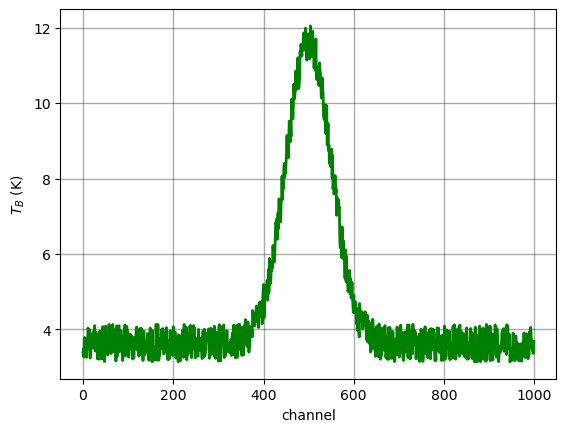

In [5]:
p.plot(color='green',grid=True,xaxis_unit="channel")

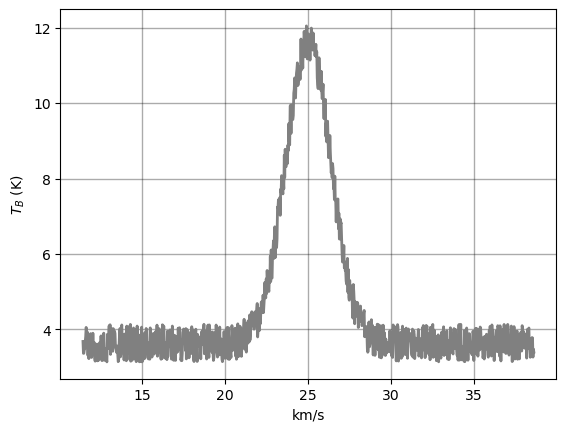

In [6]:
p.plot(color='gray',grid=True,xaxis_unit="km/s")

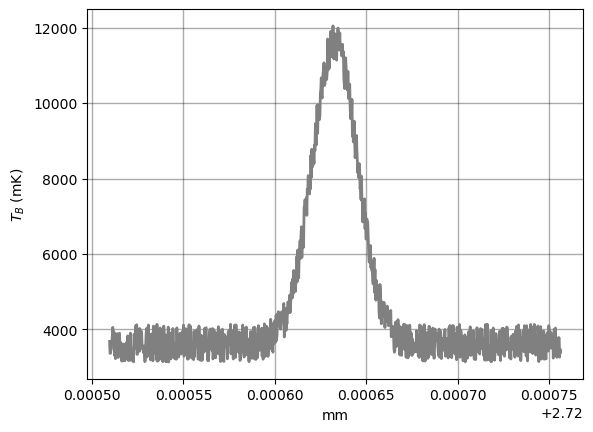

In [7]:
p.plot(xaxis_unit="mm",yaxis_unit="mK")

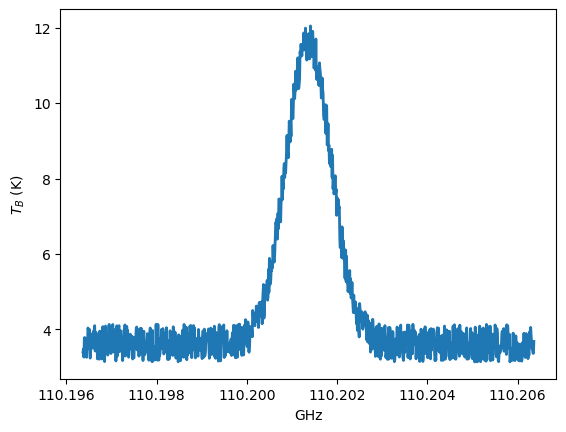

In [8]:
p.reset()
p.plot()

## Use channels for the exclude region

EXCLUDING Spectral Region, 1 sub-regions:
  (110.19937 GHz, 110.20336999999999 GHz) 



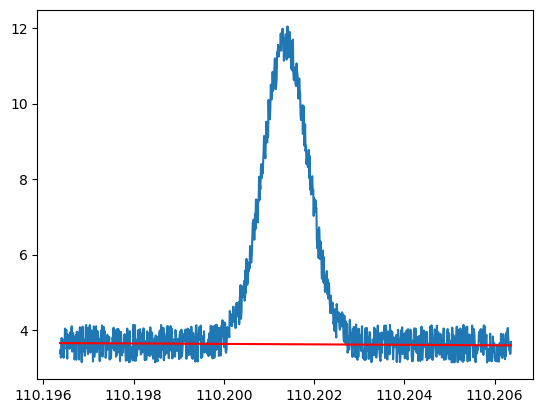

In [9]:
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
s.baseline(1,exclude=[300,700],remove=False)
ax.plot(s.spectral_axis,s._baseline_model(s.spectral_axis),color='r')

## Use a frequency Quantity for the exclude region

EXCLUDING Spectral Region, 1 sub-regions:
  (110.199 GHz, 110.2037 GHz) 


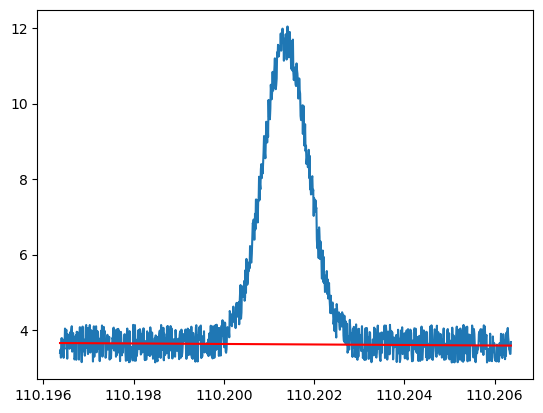

In [10]:
#s._undo_baseline()
s.baseline(1,exclude=[110.199*u.GHz,110.2037*u.GHz],remove=False)
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
ax.plot(s.spectral_axis,s._baseline_model(s.spectral_axis),color='r')

In [ ]:
s.spectral_axis[300].value,s.spectral_axis[700].value,s.velocity[300],s.velocity[700]

In [ ]:
110.19418019499935-110.20336999999999,110.19018019927493-110.19937,s.radial_velocity.to("GHz",equivalencies=s.equivalencies)-s.rest_value

EXCLUDING Spectral Region, 1 sub-regions:
  (110.19937000434334 GHz, 110.20337000006775 GHz) 



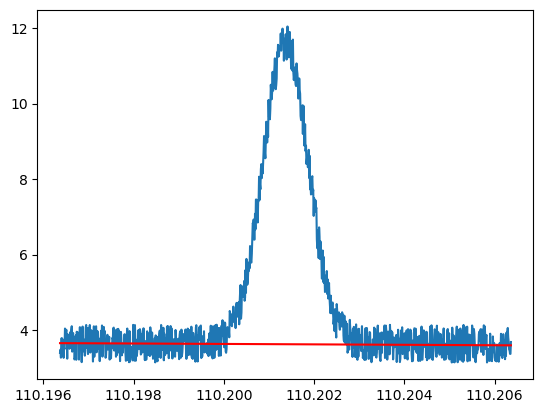

In [11]:
#s._undo_baseline()
kms = u.Unit("km/s")
s.baseline(1,exclude=[19.559188*kms,30.4408*kms],remove=False)
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
ax.plot(s.spectral_axis,s._baseline_model(s.spectral_axis),color='r')

## Lee's nasty case (github issue 36)

In [ ]:
rnge=[300,6500]
#y = 3.1415927+np.random.rand(npts)+1000*norm(loc=npts/2,scale=50).pdf(x)
#s = Spectrum(flux=y*u.K,spectral_axis=x*u.um,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))
s.baseline(1,exclude=rnge,remove=False)
fig,ax=plt.subplots()
ax.axvline(rnge[0],color='g')
#ax.axvline(rnge[1],color='g')
ax.plot(s.spectral_axis,s.flux)
ax.plot(s.spectral_axis,s._baseline_model(s.spectral_axis),color='r')

In [ ]:
npts = 1000
x = np.arange(npts)
y2 = 1.0+np.random.rand(npts)+500*norm(loc=npts/2,scale=50).pdf(x)
s2 = Spectrum(flux=y2*u.K,spectral_axis=x*u.um,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))

fig,ax=plt.subplots()
ax.plot(s2.spectral_axis,s2.flux)
s2.baseline(1,exclude=[350,6500],remove=True)
ax.plot(s2.spectral_axis,s2._baseline_model(s2.spectral_axis),color='r')
plt.show()


In [ ]:
s2.baseline_model

In [ ]:

y3=y2.copy()[0:300]
x3=x[0:300]
s3=Spectrum(flux=y3*u.K,spectral_axis=x3*u.um,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))
fig,ax=plt.subplots()
ax.plot(s3.spectral_axis,s3.flux)
s3.baseline(1,remove=True)
ax.plot(s3.spectral_axis,s3._baseline_model(s3.spectral_axis),color='r')
print(s2.baseline_model,"\n",s3.baseline_model)

### print some statistics [mean, rms, min, max], show the baseline model function

In [ ]:
print(s.stats())
s.bshow()

### now do again it and remove the baseline

In [ ]:
s = Spectrum(flux=y*u.K,spectral_axis=x*u.um,velocity_convention='doppler_radio',radial_velocity=25*u.Unit('km/s'))
s.baseline(1,exclude=[300,700],remove=True)
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.flux)
print(s.stats())
s.bshow()

In [ ]:
### undo the baseline removal.  Stats shows it has been added back in and the spectrum is restored

In [ ]:
s._undo_baseline()
print(s.stats())
s.bshow()


-------------

# 2. GBTFITSLoad and position-switch calibration testing
change to use your specific `datadir`

In [ ]:
datadir = '/data/gbt'
#f = datadir + '/examples/misc/ngc5291.fits'
f = datadir + '/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
#f = datadir + 'examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
p = GBTFITSLoad(f)

In [ ]:
p.rawspectrum(0,0)

### Print the summary.  Yes, I need to clean this up.

In [ ]:
p.summary()[0]

### check out some important columns.  Note the clever selection mechanism

In [ ]:
columns = ["SCAN","PROC","PROCSEQN","IFNUM","PLNUM","SIG","CAL","TSYS","TCAL", "OBSMODE","FDNUM"]
df = p._ptable[0]
df[df.columns & columns][0:50]
#df[(df['SIG'] == 'F') & (df['CAL']=='T')][(df.columns & columns)]

## Get a position switch scan and calibrate it.
The default ifnum=0, plnum=0

In [ ]:
# eventually this will have calibrate=True as the default, so you don't need to call calibrate().
psscan = p.getps(152)

In [ ]:
psscan.calibrate()

### the raw calibrated numpy array

In [ ]:
psscan._calibrated[0]

### A single integration of the calibrated Spectrum

In [ ]:
spec1 = psscan.calibrated(0)
spec1.unit == u.K

In [ ]:

sp = SpectrumPlot(spec1)
sp.plot(xaxis_unit="km/s")
spec1.spectral_axis.unit
ctype = ['FREQ', 'RA', 'DEC']
ctype[0] in ['FREQ']

In [ ]:
s=spec1
equiv = u.spectral()
if "RESTFREQ" in s.meta:
    cunit1 = s.meta.get("CUNIT1",s.wcs.wcs.cunit[0])
#@todo this could be done with a dict str->function
    rfq = s.meta["RESTFREQ"]*cunit1
    print("RESTFREQ is ",rfq)
    if s.velocity_convention == "doppler_radio":
        equiv.extend(u.doppler_radio(rfq))
    elif s.velocity_convention == "doppler_optical":
        equiv.extend(u.doppler_optical(rfq))
    elif s.velocity_convention == "doppler_relativistic":
        equiv.extend(u.doppler_relativistic(rfq))
    elif s.velocity_convention == "doppler_redshift":
        equiv.extend(u.doppler_redshift())
else:
    print("missing RF or CU")
s.meta["RESTFREQ"],s.spectral_axis.doppler_rest,s.spectral_axis.doppler_convention

In [ ]:
s.spectral_axis.to("km/s",equivalencies=u.doppler_radio(rfq),doppler_rest=s.spectral_axis.doppler_rest, doppler_convention="radio")

In [ ]:
spec1[300:800]

In [ ]:
fig,ax = plt.subplots()
ax.set_ylim([-4,4])
ax.plot(spec1.spectral_axis,spec1.flux)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$T_a$ (K)")

In [ ]:
## ignore this
if False:
    flx = np.mean(psscan._calibrated[np.arange(0,len(psscan._calibrated),4)])
    fig,ax = plt.subplots()
    ax.set_ylim([-4,4])
    ax.plot(psscan.calibrated(0).spectral_axis,flx)
    all(psscan.calibrated(0).spectral_axis==psscan.calibrated(3).spectral_axis),all(psscan.calibrated(4).spectral_axis==psscan.calibrated(7).spectral_axis)

### The average spectrum.  
Note this will be encapsulated in a average() method.
Compare this with GBTIDL `getps, 152`

In [ ]:
avg = Spectrum(spectral_axis=psscan.calibrated(0).spectral_axis,flux=np.mean(psscan._calibrated)*u.K)
fig,ax=plt.subplots()
ax.plot(avg.spectral_axis,avg.flux)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$T_a$ (K)")
print(f"T_sys = {np.mean(psscan.tsys)}")

### Try a different polarization and IF and use the OFF scan number
GBTIDL `getps, 153, ifnum=1, plnum=1`

In [ ]:
psscan = p.getps(153,plnum=1,ifnum=1)
psscan.calibrate()

In [ ]:
avg = Spectrum(spectral_axis=psscan.calibrated(0).spectral_axis,flux=np.mean(psscan._calibrated)*u.K)
fig,ax=plt.subplots()
ax.plot(avg.spectral_axis,avg.flux)
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(r"$T_a$ (K)")
print(f"T_sys = {np.mean(psscan.tsys)}")

-----
# Debugging from here down.

In [ ]:
df = p._ptable[0]
len(p.select('OBJECT','NGC2415',p._ptable[0]))//p.npol(0)

In [ ]:
psscan.meta

In [ ]:
p.index(0).iloc[psscan._scanrows["OFF"]]["CAL"]

In [ ]:
psscan.calibrate()

In [ ]:
df = p._ptable[0]
scans = [152,153]
df2=df[df["SCAN"].isin([152])]
df3=df[df["SCAN"].isin([153])]
df4=df[df["SCAN"].isin([156])]
un = df2.index.union(df3.index)
un2=df2.index
un3=df3.index
df["SCAN"].iloc[un2]
df3.reindex(un2).index

In [ ]:
on = [152,154,156]
off = [153,155,157]
scans = [152,155]
onrequested = set(on).intersection(scans)
offrequested = set(off).intersection(scans)
sons = list(onrequested.copy())
soffs = list(offrequested.copy())
missingoff = []
missingon = []
setoff = set(off)
seton = set(on)
for i in onrequested:
    expectedoff = i+1
    if len(setoff.intersection([expectedoff])) == 0:
        missingoff.append(expectedoff)
    else:
        soffs.append(expectedoff)
for i in offrequested:
    expectedon = i-1
    if len(seton.intersection([expectedon])) == 0:
        missingon.append(expectedon)
    else:
        sons.append(expectedon)
if len(missingoff) > 0:
    raise ValueError(f"For the requested ON scans {onrequested}, the OFF scans {missingoff} were not present in bintable {bintable}")
if len(missingon) > 0:
    raise ValueError(f"For the requested OFF scans {offrequested}, the ON scans {missingon} were not present in bintable {bintable}")
print("ON",sorted(sons))
print("OFF",sorted(soffs))

In [ ]:
scanlist=p.onoff_scan_list()
print(scanlist)
#scanlist = p.onoff_scan_list([152])
#print(scanlist)
scanlist = p.onoff_scan_list([153])
print(scanlist)
scanlist = p.onoff_scan_list([152,153])
print(scanlist)
scanlist = p.onoff_scan_list(152)
print(scanlist)

In [ ]:
print(sonoff(p.index(0)["SCAN"],p.index(0)["PROCSEQN"]))
myscans = set(sorted([153,155]))
scanlist=p.onoff_scan_list()
print(scanlist)
allscans = set(sorted(scanlist["ON"]+scanlist["OFF"]+[1,2,3,4,5]))
print(allscans)
z=allscans.intersection(myscans)
zz =allscans.difference(myscans)
zzz=myscans.difference(allscans)
print(z,zz,zzz)

In [ ]:
psscan = p.getps(scans=[152])

In [ ]:
df = p._ptable[0]
rows=list(df[df["SCAN"].isin(scans["ON"])].index)
df

In [ ]:
rows=p.onoff_rows()
rows

In [ ]:
show = ["SCAN", "PROCSEQN", "PROCSIZE", "_OBSTYPE"]
df=df[df.columns & show]
df[df["_OBSTYPE"]=="PSWITCHOFF"]

In [ ]:
dict(p._ptable[0].iloc[0])

In [ ]:
df["RESTFREQ"]/=1E9
df["RESTFREQ"]

In [ ]:
show = ["SCAN", "OBJECT", "OBSMODE", "VELOCITY", "PROCSCAN", "PROCSEQN", "PROCTYPE", "PROCSIZE", "RESTFREQ", "IFNUM","FEED", "AZIMUTH", "ELEVATIO", "FDNUM"] 
scan = [60,61]
_df = df[df.columns & show].reindex(columns=show)

In [ ]:
_df["OBSMODE"].str.split(':',expand=True)

In [ ]:

_df[(_df["SCAN"]>=scan[0]) & ( _df["SCAN"] <= scan[1])]

In [ ]:
df["SCAN"]

In [ ]:
df['PROCTYPE']